# Laboratorio: Series de Fourier
## Análisis y Síntesis de Señales Periódicas

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import ipywidgets as widgets
from IPython.display import display

import sys
sys.path.append('./labs')
from labs.serie_fourier import (
    FourierSeries,
    onda_cuadrada,
    onda_triangular,
    onda_diente_sierra,
    impulso_periodico,
    calcular_potencia,
)

plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


## 1. Introducción Teórica

### Series de Fourier - Forma Trigonométrica
Una señal periódica $f(t)$ con período $T$ puede expresarse como:

$$f(t) = \frac{a_0}{2} + \sum_{n=1}^{\infty} [a_n \cos(n\omega_0 t) + b_n \sin(n\omega_0 t)]$$

donde $\omega_0 = \frac{2\pi}{T}$ y los coeficientes son:

$$a_0 = \frac{2}{T} \int_{-T/2}^{T/2} f(t) dt$$

$$a_n = \frac{2}{T} \int_{-T/2}^{T/2} f(t) \cos(n\omega_0 t) dt$$

$$b_n = \frac{2}{T} \int_{-T/2}^{T/2} f(t) \sin(n\omega_0 t) dt$$

### Series de Fourier - Forma Exponencial Compleja
$$f(t) = \sum_{n=-\infty}^{\infty} c_n e^{jn\omega_0 t}$$

donde:
$$c_n = \frac{1}{T} \int_{-T/2}^{T/2} f(t) e^{-jn\omega_0 t} dt$$

## 2. Ejemplo 1: Onda Cuadrada

Comenzaremos analizando una onda cuadrada, una de las señales más utilizadas en el análisis de Fourier.

Coeficientes exponenciales complejos (primeros 10):
Número de coeficientes: 41
C[-5] =  -0.0002 + j  0.0002 =   0.0003∠ 135.0°
C[-4] =   0.0002 + j -0.0000 =   0.0002∠  -0.0°
C[-3] =  -0.0002 + j -0.0002 =   0.0003∠-135.0°
C[-2] =   0.0002 + j  1.2731 =   1.2731∠  90.0°
C[-1] =  -0.0002 + j  0.0002 =   0.0003∠ 135.0°
C[ 0] =   0.0002 + j  0.0000 =   0.0002∠   0.0°
C[ 1] =  -0.0002 + j -0.0002 =   0.0003∠-135.0°
C[ 2] =   0.0002 + j -1.2731 =   1.2731∠ -90.0°
C[ 3] =  -0.0002 + j  0.0002 =   0.0003∠ 135.0°
C[ 4] =   0.0002 + j  0.0000 =   0.0002∠   0.0°
C[ 5] =  -0.0002 + j -0.0002 =   0.0003∠-135.0°


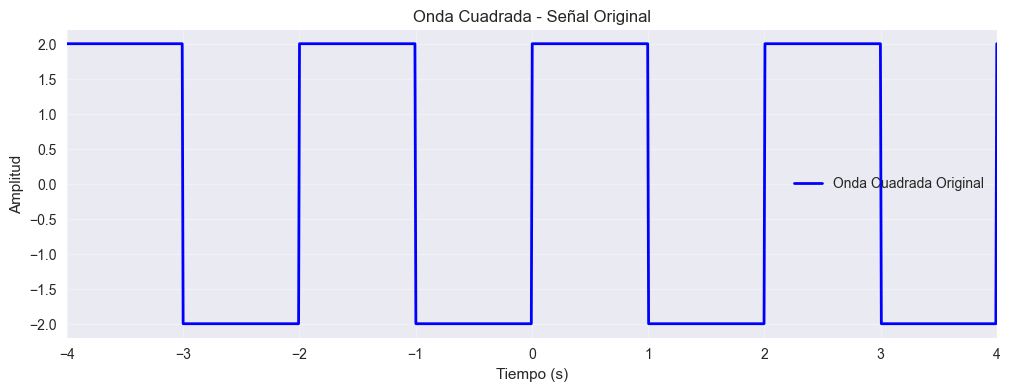

In [9]:
T = 4  # Período
fs = FourierSeries(periodo=T)

t_vis = np.linspace(-T, T, 1000)

cuadrada = lambda t: onda_cuadrada(t, amplitud=2, duty_cycle=0.5)
y_original = cuadrada(t_vis)

n_vector, cn = fs.coeficientes_exponenciales(cuadrada, n_harmonicos=20)

print(f"Coeficientes exponenciales complejos (primeros 10):")
print(f"Número de coeficientes: {len(cn)}")
for i, (n, c) in enumerate(zip(n_vector, cn)):
    if abs(n) <= 5:
        print(f"C[{n:2d}] = {c.real:8.4f} + j{c.imag:8.4f} = {abs(c):8.4f}∠{np.angle(c)*180/np.pi:6.1f}°")

plt.figure(figsize=(12, 4))
plt.plot(t_vis, y_original, 'b-', linewidth=2, label='Onda Cuadrada Original')
plt.grid(True, alpha=0.3)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Onda Cuadrada - Señal Original')
plt.legend()
plt.xlim(-T, T)
plt.show()

### Aproximaciones con Diferentes Números de Armónicos

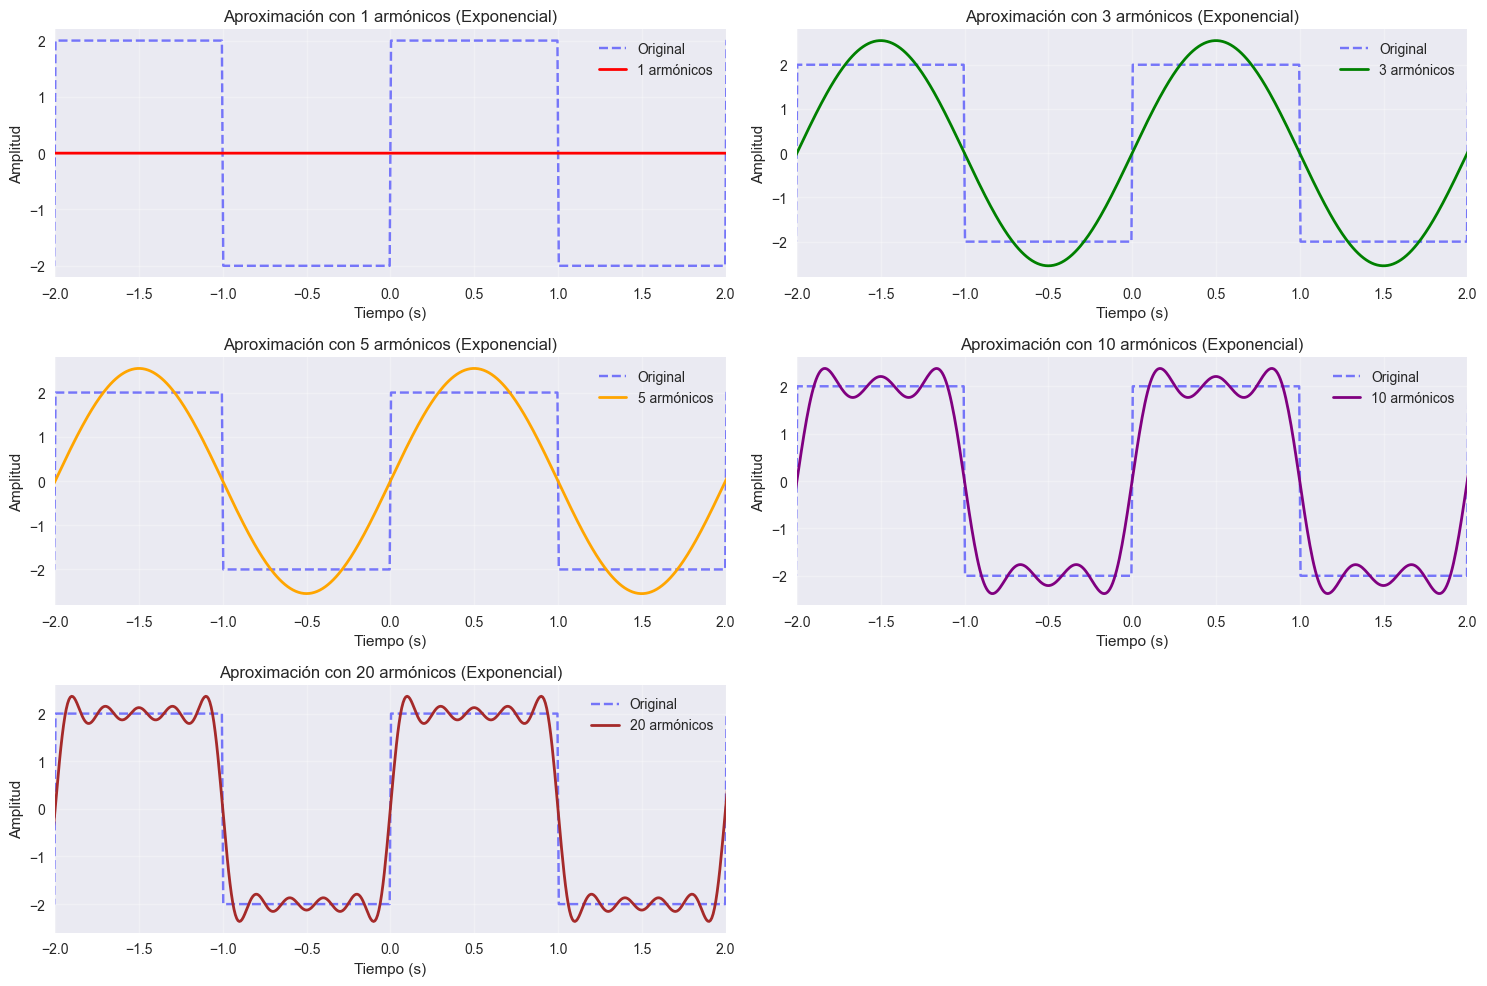


Error RMS vs Número de Armónicos (Síntesis Exponencial):
 1 armónicos: Error RMS = 2.000001
 3 armónicos: Error RMS = 0.872339
 5 armónicos: Error RMS = 0.872340
10 armónicos: Error RMS = 0.521089
20 armónicos: Error RMS = 0.406771


In [10]:
def sintetizar_serie_exponencial(n_vector, cn, t, n_terminos=None):
    """
    Sintetizar señal usando coeficientes exponenciales complejos
    """
    if n_terminos is None:
        indices = np.arange(len(cn))
    else:
        centro = len(cn) // 2
        inicio = max(0, centro - n_terminos)
        fin = min(len(cn), centro + n_terminos + 1)
        indices = np.arange(inicio, fin)

    omega0 = 2 * np.pi / T
    resultado = np.zeros_like(t, dtype=complex)

    for i in indices:
        n = n_vector[i]
        resultado += cn[i] * np.exp(1j * n * omega0 * t)

    return np.real(resultado)

n_terminos_list = [1, 3, 5, 10, 20]
colores = ['red', 'green', 'orange', 'purple', 'brown']

plt.figure(figsize=(15, 10))

for i, n_terminos in enumerate(n_terminos_list):
    plt.subplot(3, 2, i+1)

    y_aprox = sintetizar_serie_exponencial(n_vector, cn, t_vis, n_terminos)

    plt.plot(t_vis, y_original, 'b--', alpha=0.5, label='Original')
    plt.plot(t_vis, y_aprox, colores[i], linewidth=2, label=f'{n_terminos} armónicos')

    plt.grid(True, alpha=0.3)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(f'Aproximación con {n_terminos} armónicos (Exponencial)')
    plt.legend()
    plt.xlim(-T/2, T/2)

plt.tight_layout()
plt.show()

print("\nError RMS vs Número de Armónicos (Síntesis Exponencial):")
for n_terminos in n_terminos_list:
    y_aprox = sintetizar_serie_exponencial(n_vector, cn, t_vis, n_terminos)
    error_rms = np.sqrt(np.mean((y_original - y_aprox)**2))
    print(f"{n_terminos:2d} armónicos: Error RMS = {error_rms:.6f}")

## 3. Espectro de Frecuencias

Analicemos el contenido en frecuencia de la onda cuadrada.

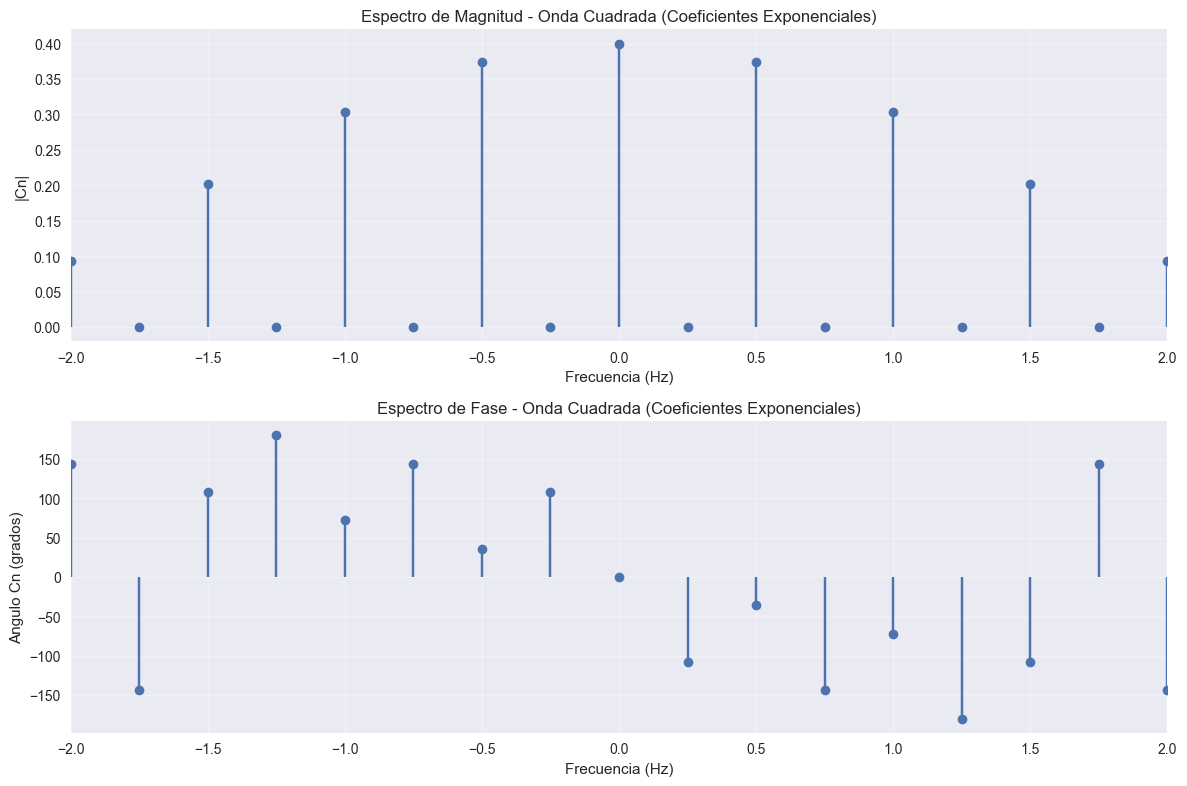


Coeficientes Exponenciales Complejos:
C[-8] =  -0.0756 + j  0.0550
      |C[-8]| =   0.0935, ∠C[-8] =  143.9°

C[-7] =  -0.0001 + j -0.0001
      |C[-7]| =   0.0002, ∠C[-7] = -144.1°

C[-6] =  -0.0622 + j  0.1920
      |C[-6]| =   0.2018, ∠C[-6] =  108.0°

C[-5] =  -0.0002 + j  0.0000
      |C[-5]| =   0.0002, ∠C[-5] =  180.0°

C[-4] =   0.0937 + j  0.2878
      |C[-4]| =   0.3027, ∠C[-4] =   72.0°

C[-3] =  -0.0001 + j  0.0001
      |C[-3]| =   0.0002, ∠C[-3] =  144.0°

C[-2] =   0.3028 + j  0.2199
      |C[-2]| =   0.3742, ∠C[-2] =   36.0°

C[-1] =  -0.0000 + j  0.0001
      |C[-1]| =   0.0001, ∠C[-1] =  108.0°

C[ 0] =   0.4000 + j  0.0000
      |C[ 0]| =   0.4000, ∠C[ 0] =    0.0°

C[ 1] =  -0.0000 + j -0.0001
      |C[ 1]| =   0.0001, ∠C[ 1] = -108.0°

C[ 2] =   0.3028 + j -0.2199
      |C[ 2]| =   0.3742, ∠C[ 2] =  -36.0°

C[ 3] =  -0.0001 + j -0.0001
      |C[ 3]| =   0.0002, ∠C[ 3] = -144.0°

C[ 4] =   0.0937 + j -0.2878
      |C[ 4]| =   0.3027, ∠C[ 4] =  -72.0°

C[ 5] =  -0.

In [15]:
frecuencias = n_vector * fs.omega0 / (2 * np.pi)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

magnitudes = np.abs(cn)
ax1.stem(frecuencias, magnitudes, basefmt=" ")
ax1.set_xlabel('Frecuencia (Hz)')
ax1.set_ylabel('|Cn|')
ax1.set_title('Espectro de Magnitud - Onda Cuadrada (Coeficientes Exponenciales)')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-2, 2)

fases = np.angle(cn) * 180 / np.pi
ax2.stem(frecuencias, fases, basefmt=" ")
ax2.set_xlabel('Frecuencia (Hz)')
ax2.set_ylabel('Angulo Cn (grados)')
ax2.set_title('Espectro de Fase - Onda Cuadrada (Coeficientes Exponenciales)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-2, 2)

plt.tight_layout()
plt.show()

print("\nCoeficientes Exponenciales Complejos:")
for i, (n, c) in enumerate(zip(n_vector, cn)):
    if abs(n) <= 8:
        magnitude = abs(c)
        phase = np.angle(c) * 180 / np.pi
        print(f"C[{n:2d}] = {c.real:8.4f} + j{c.imag:8.4f}")
        print(f"      |C[{n:2d}]| = {magnitude:8.4f}, ∠C[{n:2d}] = {phase:6.1f}°")
        print()

## 4. Comparación entre Diferentes Señales

Analicemos y comparemos diferentes tipos de señales periódicas.

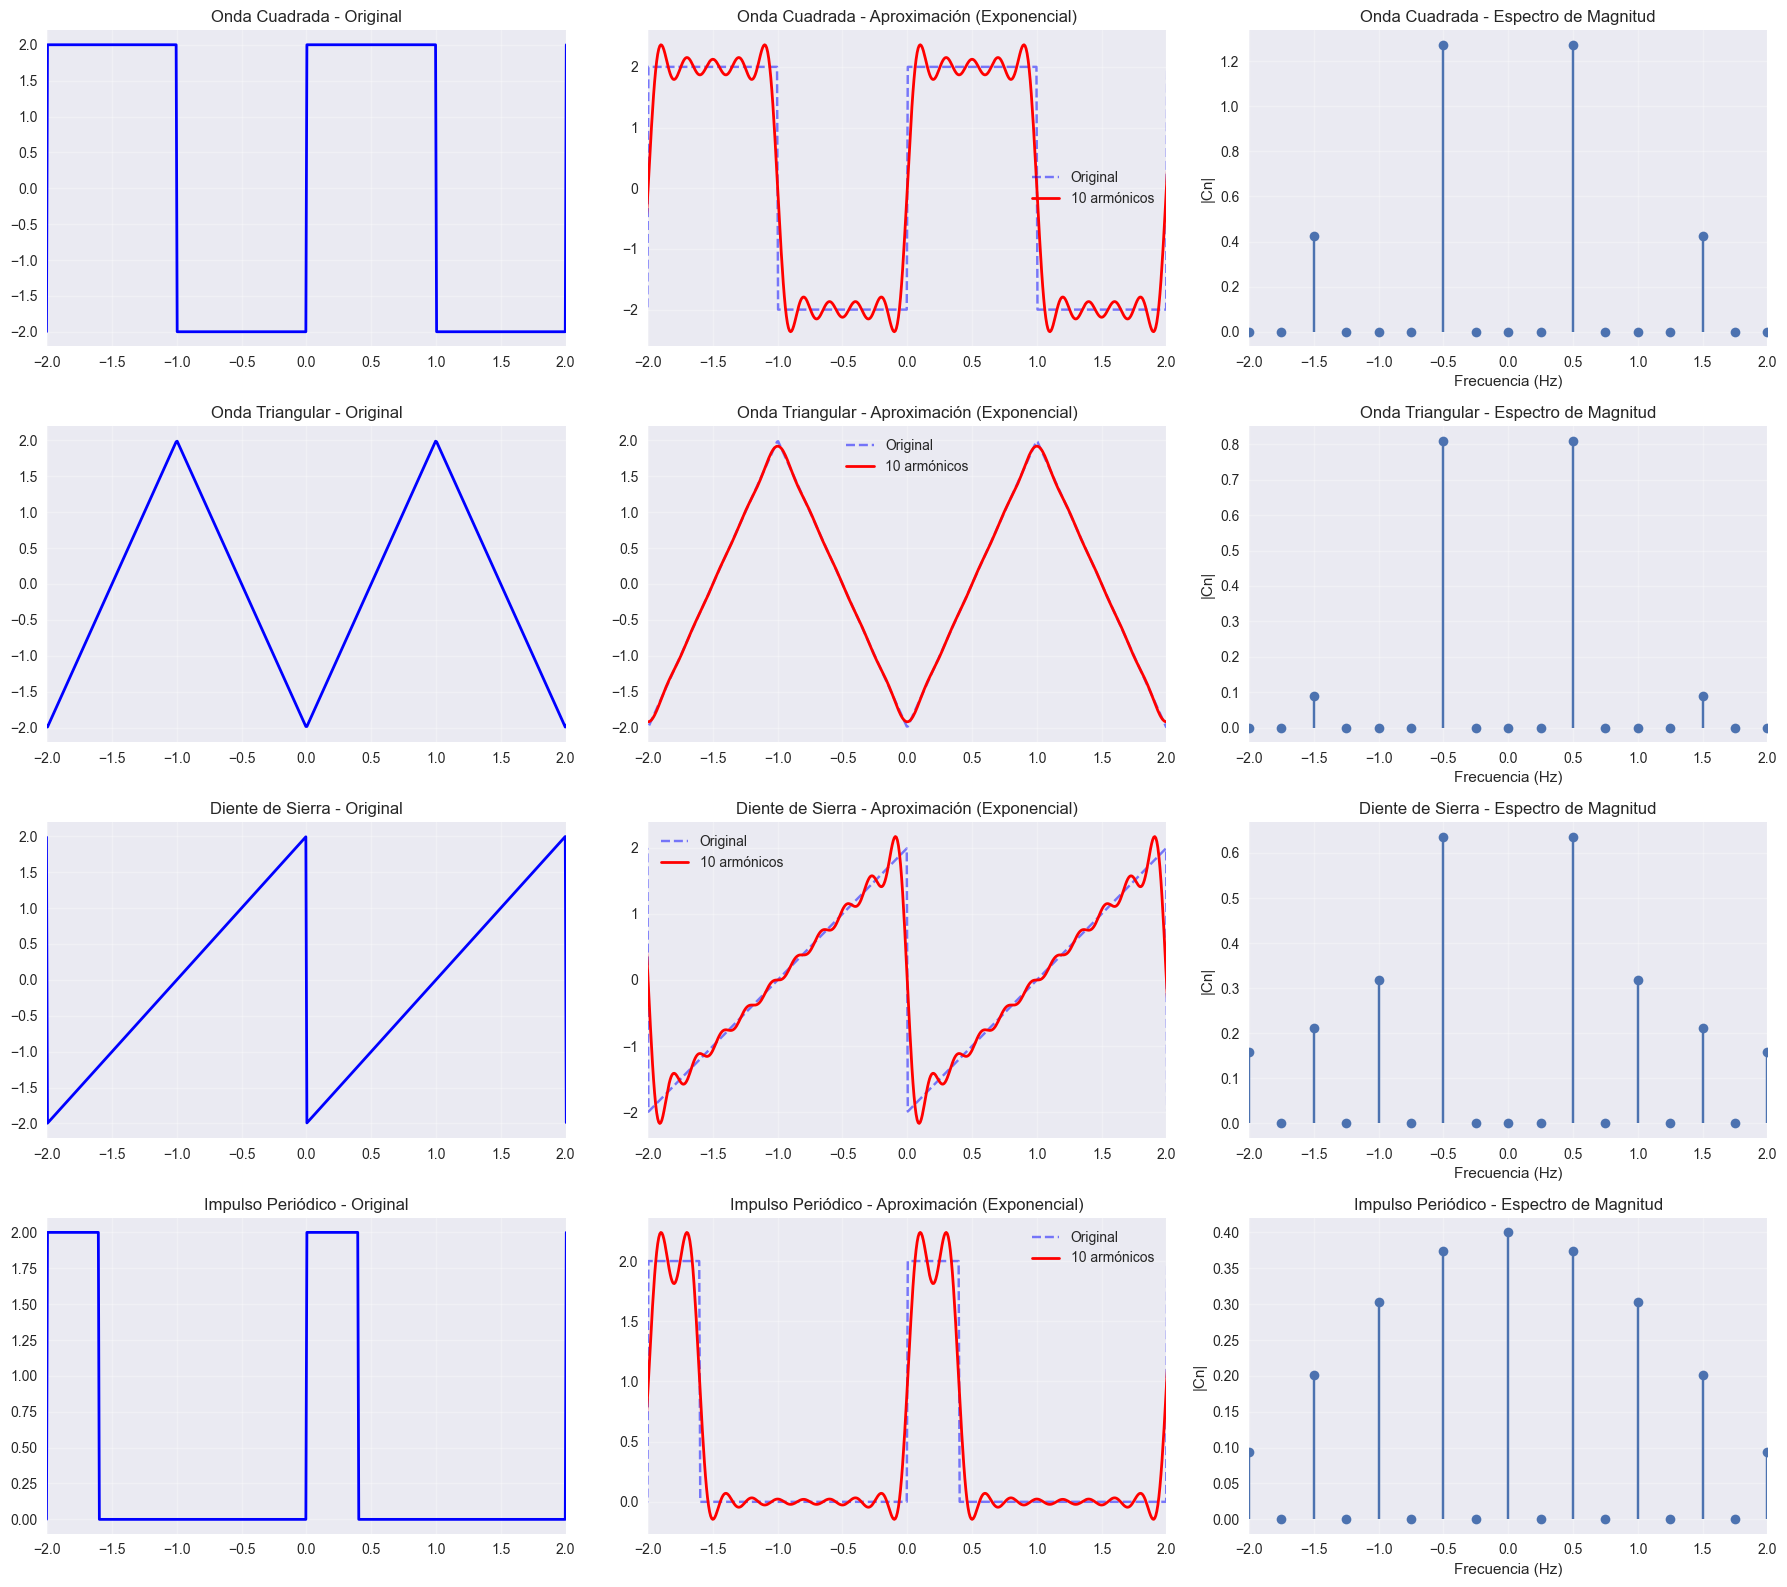

In [19]:
senales = {
    'Onda Cuadrada': lambda t: onda_cuadrada(t, amplitud=2),
    'Onda Triangular': lambda t: onda_triangular(t, amplitud=2),
    'Diente de Sierra': lambda t: onda_diente_sierra(t, amplitud=2),
    'Impulso Periódico': lambda t: impulso_periodico(t, amplitud=2, ancho=0.2)
}

T = 4
fs = FourierSeries(periodo=T)
t_vis = np.linspace(-T, T, 1000)
n_harmonicos = 20

resultados = {}

fig, axes = plt.subplots(4, 3, figsize=(18, 16))

for i, (nombre, func) in enumerate(senales.items()):
    n_vector, cn = fs.coeficientes_exponenciales(func, n_harmonicos)

    resultados[nombre] = {'cn': cn, 'n_vector': n_vector}

    y_original = func(t_vis)
    axes[i, 0].plot(t_vis, y_original, 'b-', linewidth=2)
    axes[i, 0].set_title(f'{nombre} - Original')
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].set_xlim(-T/2, T/2)

    y_aprox = sintetizar_serie_exponencial(n_vector, cn, t_vis, n_harmonicos)
    axes[i, 1].plot(t_vis, y_original, 'b--', alpha=0.5, label='Original')
    axes[i, 1].plot(t_vis, y_aprox, 'r-', linewidth=2, label='10 armónicos')
    axes[i, 1].set_title(f'{nombre} - Aproximación (Exponencial)')
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].legend()
    axes[i, 1].set_xlim(-T/2, T/2)

    frecuencias = n_vector * fs.omega0 / (2 * np.pi)
    magnitudes = np.abs(cn)
    axes[i, 2].stem(frecuencias, magnitudes, basefmt=" ")
    axes[i, 2].set_title(f'{nombre} - Espectro de Magnitud')
    axes[i, 2].grid(True, alpha=0.3)
    axes[i, 2].set_xlim(-2, 2)
    axes[i, 2].set_xlabel('Frecuencia (Hz)')
    axes[i, 2].set_ylabel('|Cn|')

plt.tight_layout()
plt.show()

## 6. Laboratorio Interactivo

### Ejercicio 1: Exploración Interactiva de Aproximaciones

In [25]:
def visualizador_interactivo(tipo_senal='Cuadrada', n_armonicos=10, amplitud=2.0, duty_cycle=0.5):
    T = 4
    fs = FourierSeries(periodo=T)
    t_vis = np.linspace(-T, T, 1000)

    if tipo_senal == 'Cuadrada':
        func = lambda t: onda_cuadrada(t, amplitud, duty_cycle)
    elif tipo_senal == 'Triangular':
        func = lambda t: onda_triangular(t, amplitud)
    elif tipo_senal == 'Diente de Sierra':
        func = lambda t: onda_diente_sierra(t, amplitud)
    elif tipo_senal == 'Impulso Periódico':
        func = lambda t: impulso_periodico(t, amplitud, duty_cycle)

    n_vector, cn = fs.coeficientes_exponenciales(func, max(n_armonicos, 20))

    y_original = func(t_vis)
    y_aprox = sintetizar_serie_exponencial(n_vector, cn, t_vis, n_armonicos)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    ax1.plot(t_vis, y_original, 'b-', linewidth=2, label='Original', alpha=0.7)
    ax1.plot(t_vis, y_aprox, 'r-', linewidth=2, label=f'Aproximación ({n_armonicos} armónicos)')
    ax1.set_xlabel('Tiempo (s)')
    ax1.set_ylabel('Amplitud')
    ax1.set_title(f'Onda {tipo_senal} - Aproximación de Fourier (Exponencial)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-T/2, T/2)

    error_rms = np.sqrt(np.mean((y_original - y_aprox)**2))
    ax1.text(0.02, 0.95, f'Error RMS: {error_rms:.4f}',
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    frecuencias = n_vector * fs.omega0 / (2 * np.pi)
    magnitudes = np.abs(cn)

    mask = (np.abs(n_vector) <= n_armonicos) & (magnitudes > 1e-6)

    ax2.stem(frecuencias[mask], magnitudes[mask], basefmt=" ")
    ax2.set_xlabel('Frecuencia (Hz)')
    ax2.set_ylabel('|Cn|')
    ax2.set_title('Espectro de Magnitud - Coeficientes Exponenciales')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(-2, 2)

    plt.tight_layout()
    plt.show()

widgets_interactivo = widgets.interactive(
    visualizador_interactivo,
    tipo_senal=widgets.Dropdown(
        options=['Cuadrada', 'Triangular', 'Diente de Sierra', 'Impulso Periódico'],
        value='Cuadrada',
        description='Tipo de Señal:'
    ),
    n_armonicos=widgets.IntSlider(
        value=10,
        min=1,
        max=50,
        step=1,
        description='N° Armónicos:'
    ),
    amplitud=widgets.FloatSlider(
        value=2.0,
        min=0.5,
        max=5.0,
        step=0.1,
        description='Amplitud:'
    ),
    duty_cycle=widgets.FloatSlider(
        value=0.5,
        min=0.1,
        max=0.9,
        step=0.1,
        description='Duty Cycle:'
    )
)

display(widgets_interactivo)

interactive(children=(Dropdown(description='Tipo de Señal:', options=('Cuadrada', 'Triangular', 'Diente de Sie…

## 7. Ejercicios Prácticos

### Ejercicio 1: Señal Personalizada
Crea tu propia señal periódica y analiza sus coeficientes de Fourier.

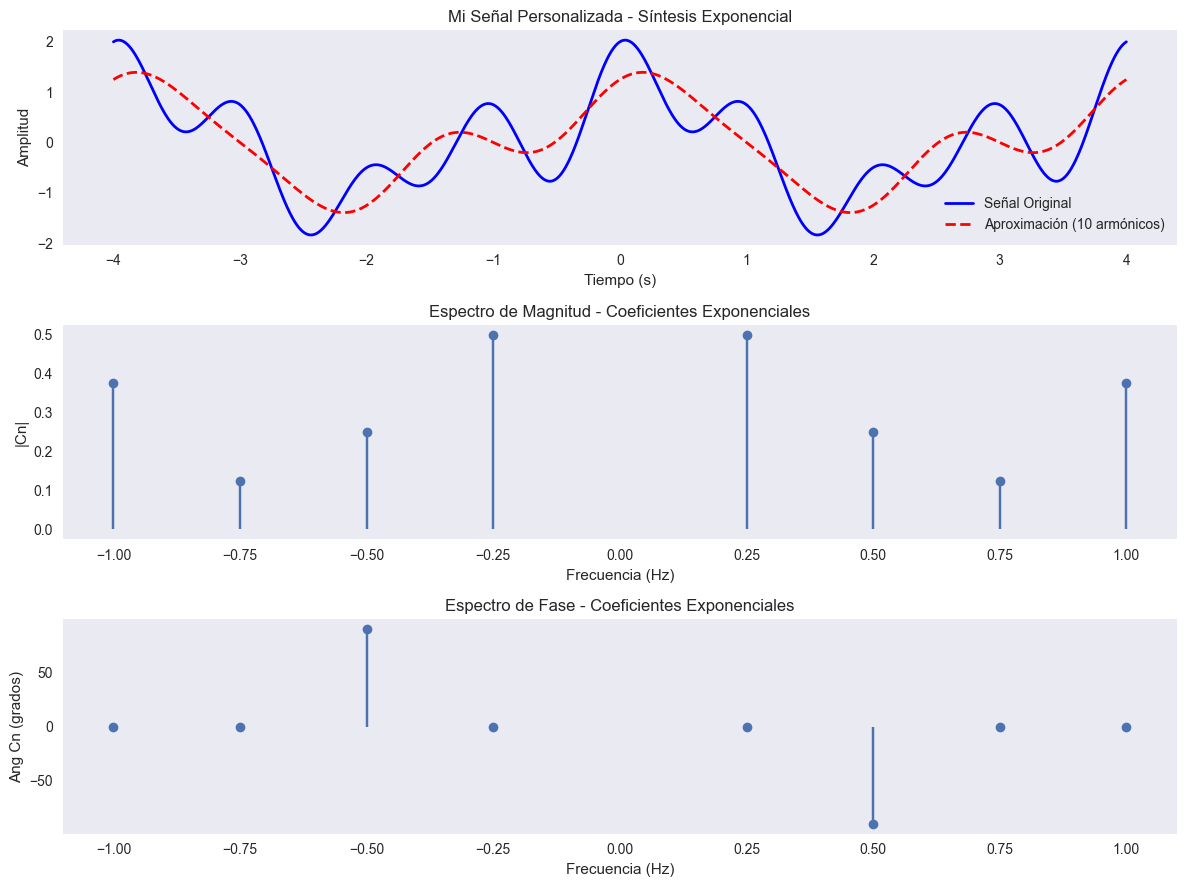


🎯 Coeficientes exponenciales de tu señal personalizada:
Coeficientes más significativos:
C[-4] =   0.3750 + j -0.0000
      |C[-4]| =   0.3750, ∠C[-4] =   -0.0°
C[-3] =   0.1250 + j  0.0000
      |C[-3]| =   0.1250, ∠C[-3] =    0.0°
C[-2] =   0.0000 + j  0.2500
      |C[-2]| =   0.2500, ∠C[-2] =   90.0°
C[-1] =   0.5000 + j  0.0000
      |C[-1]| =   0.5000, ∠C[-1] =    0.0°
C[ 1] =   0.5000 + j -0.0000
      |C[ 1]| =   0.5000, ∠C[ 1] =   -0.0°
C[ 2] =   0.0000 + j -0.2500
      |C[ 2]| =   0.2500, ∠C[ 2] =  -90.0°
C[ 3] =   0.1250 + j  0.0000
      |C[ 3]| =   0.1250, ∠C[ 3] =    0.0°
C[ 4] =   0.3750 + j  0.0000
      |C[ 4]| =   0.3750, ∠C[ 4] =    0.0°


In [ ]:
def generar_senal(t):
    return np.cos(2*np.pi*t/4) + 0.5*np.sin(4*np.pi*t/4) + 0.25*np.cos(6*np.pi*t/4) + 0.75*np.cos(8*np.pi*t/4)

T = 4
fs = FourierSeries(periodo=T)
t = np.linspace(-T, T, 1000)

n_vector, cn = fs.coeficientes_exponenciales(
    generar_senal, n_harmonicos=21
)

y_original = generar_senal(t)
y_aprox = sintetizar_serie_exponencial(n_vector, cn, t, 3)

plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.plot(t, y_original, 'b-', linewidth=2, label='Señal Original')
plt.plot(t, y_aprox, 'r--', linewidth=2, label='Aproximación (10 armónicos)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Mi Señal Personalizada - Síntesis Exponencial')
plt.legend()
plt.grid()
# plt.xlim(-T/2, T/2)

plt.subplot(3, 1, 2)
frecuencias_custom = n_vector * fs.omega0 / (2 * np.pi)
magnitudes_custom = np.abs(cn)
mask_custom = magnitudes_custom > 1e-6
plt.stem(frecuencias_custom[mask_custom], magnitudes_custom[mask_custom], basefmt=" ")
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('|Cn|')
plt.title('Espectro de Magnitud - Coeficientes Exponenciales')
plt.grid()

plt.subplot(3, 1, 3)
fases_custom = np.angle(cn) * 180 / np.pi
plt.stem(frecuencias_custom[mask_custom], fases_custom[mask_custom], basefmt=" ")
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Ang Cn (grados)')
plt.title('Espectro de Fase - Coeficientes Exponenciales')
plt.grid()

plt.tight_layout()
plt.show()

print("\nCoeficientes exponenciales de tu señal personalizada:")
print("Coeficientes más significativos:")
indices_sig = np.where(np.abs(cn) > 1e-6)[0]
for idx in indices_sig:
    n = n_vector[idx]
    c = cn[idx]
    print(f"C[{n:2d}] = {c.real:8.4f} + j{c.imag:8.4f}")
    print(f"      |C[{n:2d}]| = {abs(c):8.4f}, ∠C[{n:2d}] = {np.angle(c)*180/np.pi:6.1f}°")

### Ejercicio 2: Análisis de Convergencia
Estudia cómo mejora la aproximación al aumentar el número de armónicos.

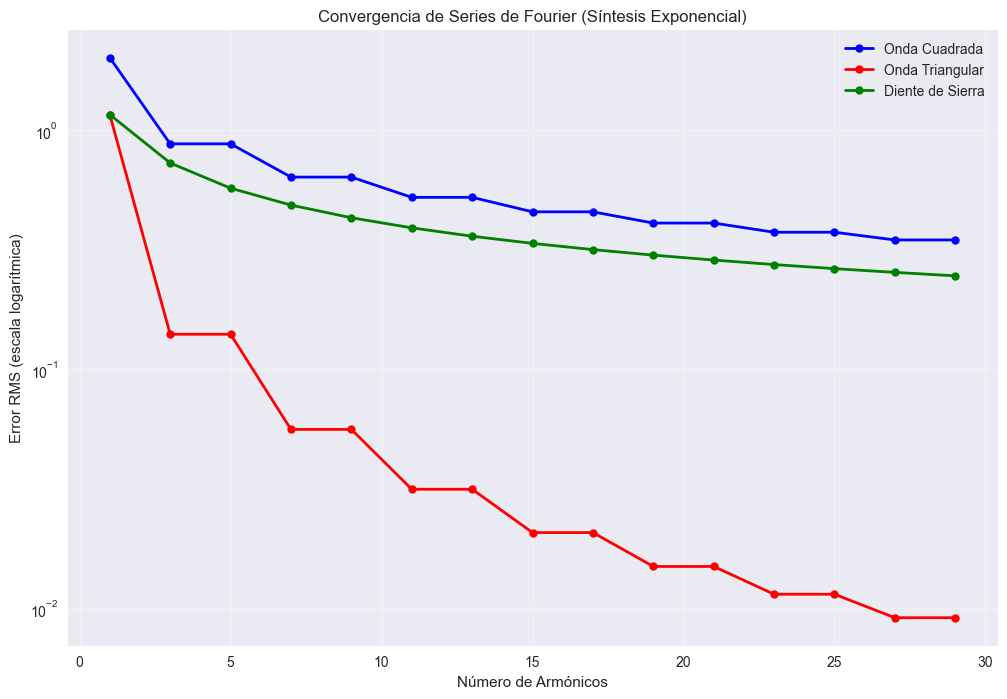

In [24]:
def analizar_convergencia_exponencial(func, nombre, max_armonicos=50):
    T = 4
    fs = FourierSeries(periodo=T)
    t_vis = np.linspace(-T/2, T/2, 1000)

    n_vector, cn = fs.coeficientes_exponenciales(func, max_armonicos)
    y_original = func(t_vis)

    n_armonicos_range = range(1, max_armonicos + 1, 2)
    errores_rms = []

    for n in n_armonicos_range:
        y_aprox = sintetizar_serie_exponencial(n_vector, cn, t_vis, n)
        error_rms = np.sqrt(np.mean((y_original - y_aprox)**2))
        errores_rms.append(error_rms)

    return list(n_armonicos_range), errores_rms

señales_convergencia = {
    'Onda Cuadrada': lambda t: onda_cuadrada(t, 2),
    'Onda Triangular': lambda t: onda_triangular(t, 2),
    'Diente de Sierra': lambda t: onda_diente_sierra(t, 2)
}

plt.figure(figsize=(12, 8))

colores = ['blue', 'red', 'green']
for i, (nombre, func) in enumerate(señales_convergencia.items()):
    n_vals, errores = analizar_convergencia_exponencial(func, nombre, 30)
    plt.semilogy(n_vals, errores, 'o-', color=colores[i],
                linewidth=2, markersize=6, label=nombre)

plt.xlabel('Número de Armónicos')
plt.ylabel('Error RMS (escala logarítmica)')
plt.title('Convergencia de Series de Fourier (Síntesis Exponencial)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()